#**Feature Engineering and Model Optimization**

---

**Objectives**:

This notebook builds on the [baseline regression model](https://github.com/MJBantayan/Machine-Learning-Portfolio/blob/main/01_RegressionModels_HousingPrices/02_EDA_and_BaselineRegression.ipynb) that I developed in the previous notebook by

* Testing the assumptions of linear regression,

* Engineering new and more informative features,

* Training ensemble models (Random Forest, Gradient Boosting, HistGradientBoosting),

* Optimizing model performance through hyperparameter tuning using GridSearchCV and other methods

* Identifying the top predictors of SalesPrice

###**1. Testing the Assumptions of Regression**:

---

####**1.1. Importing Libraries and Modules**:

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Load data:

In [2]:
pd.set_option('display.max_columns', None)

df_validate = pd.read_csv('housing_train_cleaned.csv', keep_default_na=False, na_values=[])
df_validate.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,0,12,2008,WD,Normal,250000


####**1.2. Rerunning the Baseline Regression**:

Define input data and target data (let's just copy this from notebook_01):

In [3]:
# Numeric columns (exclude target and date columns)
num_cols = df_validate.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [col for col in num_cols if col not in ['SalePrice', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']]

# Binary columns
binary_cols = ['CentralAir', 'Street', 'Utilities']

# Map binary features to 0/1
df_validate['CentralAir'] = df_validate['CentralAir'].map({'Y':1, 'N':0})
df_validate['Street'] = df_validate['Street'].map({'Pave':1, 'Grvl':0})
df_validate['Utilities'] = df_validate['Utilities'].map({'AllPub':1, 'NoSeWa':0})

# Optional ordinal features (quick baseline)
ordinal_cols_baseline = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',
                         'KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df_validate[ordinal_cols_baseline] = enc.fit_transform(df_validate[ordinal_cols_baseline])

#Nominal features for quick one-hot
nominal_cols_baseline = ['Neighborhood','MSZoning']

X = df_validate[num_cols + binary_cols + ordinal_cols_baseline + nominal_cols_baseline]
y = df_validate['SalePrice']

Rerun baseline from joblib:

In [4]:
import joblib

preprocessor_loaded = joblib.load('preprocessor.joblib')
pipeline_loaded = joblib.load('pipeline.joblib')


In [5]:
preprocessor_loaded.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = pipeline_loaded.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R^2 score:", r2)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)


R^2 score: 0.8590282484924592
MSE: 1081299320.0613616
RMSE: 32883.11603332874
MAE: 19871.62224185588


Now that we have loaded and ran the baseline regression we can use it as basis for comparison for other regression models. Before we do that let's validate the regression by checking the assumptions:

####**1.3. Linearity Check**:

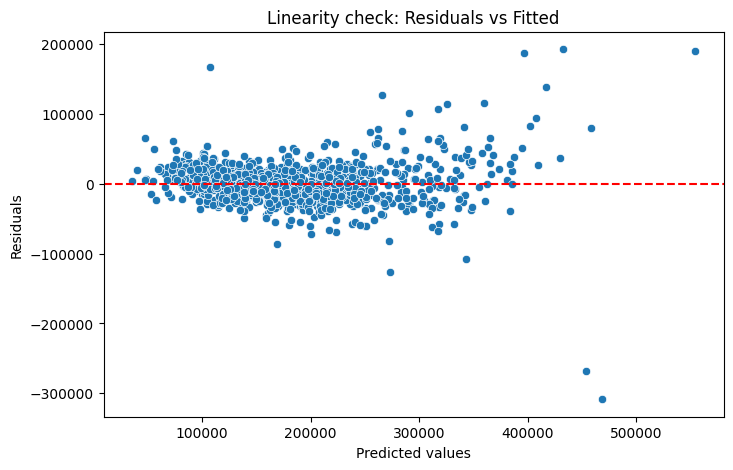

In [6]:
y_pred = pipeline_loaded.predict(X_train)
residuals = y_train - y_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Linearity check: Residuals vs Fitted")
plt.show()

####**1.4 Indepence of Errors**:

In [7]:
from statsmodels.stats.stattools import durbin_watson
print("Durbin-Watson:", durbin_watson(residuals))


Durbin-Watson: 2.1093429748147674


A Durbin-Watson statistic of **2.109** suggests that there is **no significant correlation** in the residuals of the regression model. Since this value is very close to the ideal value of 2, the assumption of independent errors is likely met.

####**1.5 Homoscedasticity**:

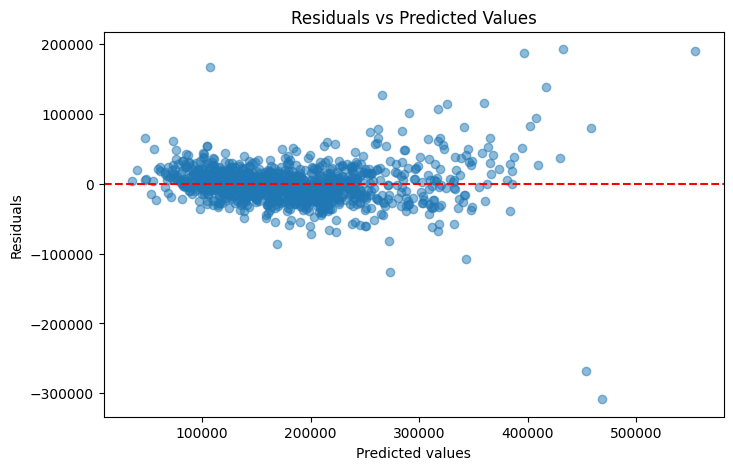

In [8]:
y_pred = pipeline_loaded.predict(X_train)
residuals = y_train - y_pred

# plot
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

**Interpretation of heteroscedasticity**

**Pattern**:

On the left (lower predicted values), the residuals are fairly tightly clustered.

On the right (higher predicted values), the spread of residuals increases dramatically, forming a “fan” or “triangle” shape.

**Conclusion**:


This is classic **heteroscedasticity**.

The variance of residuals is not constant; it grows as predicted values increase.

Linear regression assumption of constant variance is violated here.

**Implications**:


Predictions for higher-valued houses are less reliable (higher error variance).

High bias if not corrected.

####**1.6. Normality of Residuals**:

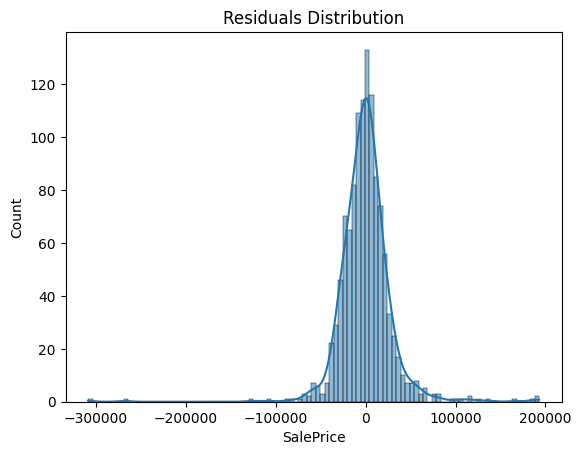

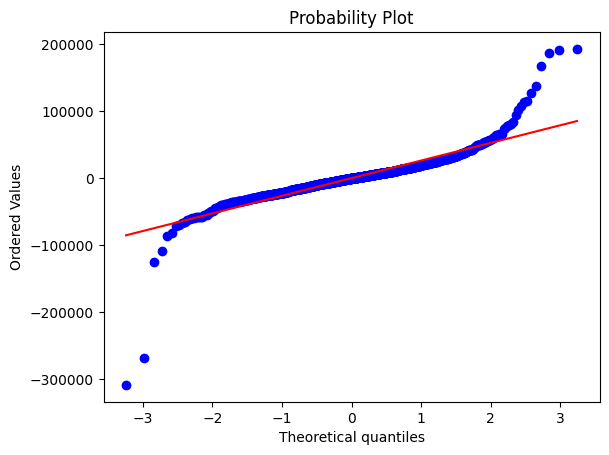

Shapiro-Wilk test: ShapiroResult(statistic=np.float64(0.8208149104889121), pvalue=np.float64(3.5131882518213086e-34))


In [9]:
import scipy.stats as stats
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

from scipy.stats import shapiro
print("Shapiro-Wilk test:", shapiro(residuals))


The histogram shows the residuals are highly concentrated near zero, with long tails that taper off more quickly than a true normal distribution might. It has a slightly sharper peak than a perfect bell curve.

The Q-Q plot shows that not all lines line within the diagonal line, breaking normality.

Lastly the **Shapiro-Wilk test** which has the null hypothesis that the distribution is normal, got the p-value that is very very small, since p < 0.05 we reject the null hypothesis and this means the distribution is not normal.

####**1.7. Interpretation**:

---

The assumptions of linear regression are mostly satisfied:

* The **linearity check** shows that the residuals are mostly scattered evenly around y = 0. There is no visible curvature so the model is linear enough.

* The **Durbin-Watson** statistic of approx. **= 2** shows that the residuals does not have any strong positive or negative correlation. The **residuals are independent**.

* The residual plot shows that the residuals are **heteroscedastic**, or their variance increases.

* The **histogram** and **Q-Q plot** shows that the distribution of residuals is **not normal**.

To normalize the distribution of the residuals and achieve homoscedasticity we will have to log-scale our target variable `SalePrice` and retrain the model, then we will test for sccedasticity and normality again.

###**2. Transforming Target Variable and Retraining Model**:

---

Since our baseline model failed the test of linear regression assumption, we need to re-scale the target variable `SalesPrice` and rerun the whole pipeline, then compare the residuals with `y_pred` for confirmation. The very narrow histogram suggests a lot of values cluster close to zero while the increasing distance of points in the residual plot suggests increasing variance. To resolve this we will log-scale the target variable.

####**2.1 Log-Scaling the target variable**:

In [10]:
X = df_validate[num_cols + binary_cols + ordinal_cols_baseline + nominal_cols_baseline]
y = df_validate['SalePrice']

y_log = np.log(y)

In [11]:
preprocessor_loaded = joblib.load('preprocessor.joblib')
pipeline_loaded = joblib.load('pipeline.joblib')

####**2.2 Training the Baseline Regressor on the newly scaled target variable**:

In [12]:
preprocessor_loaded.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

pipeline_loaded.fit(X_train, y_train)
y_pred_log = pipeline_loaded.predict(X_test)

r2 = r2_score(y_test, y_pred_log)
print("R^2 score:", r2)


R^2 score: 0.906074733057091


####**2.3 Evaluating new model**:

In [13]:
y_pred_orig = np.exp(y_pred_log)
y_test_orig = np.exp(y_test)

mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

print("R^2 score: 0.906074733057091")
print("MAE:", mae_orig)
print("MSE:", mse_orig)
print("RMSE:", rmse_orig)

R^2 score: 0.906074733057091
MAE: 16833.95927705848
MSE: 682604203.8499786
RMSE: 26126.695233993498


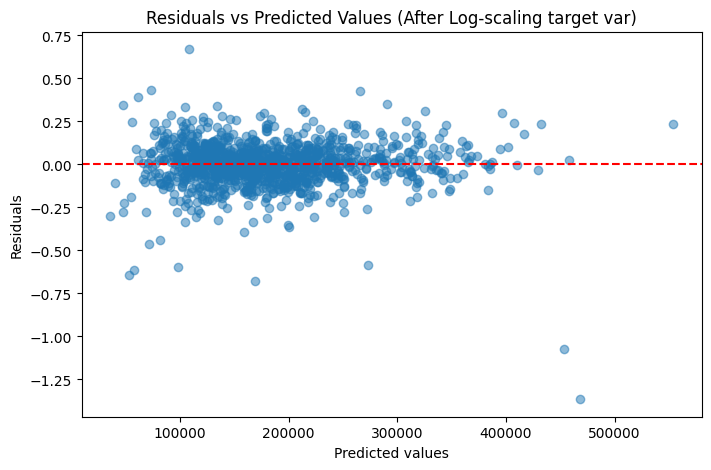

In [14]:
y_pred_log = pipeline_loaded.predict(X_train)
residuals = y_train - y_pred_log

# plot
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values (After Log-scaling target var)")
plt.show()

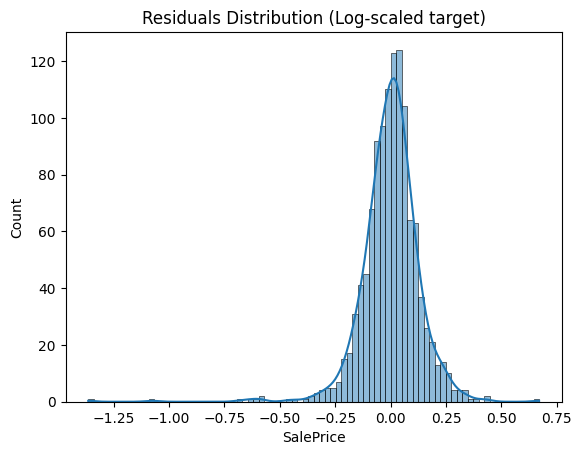

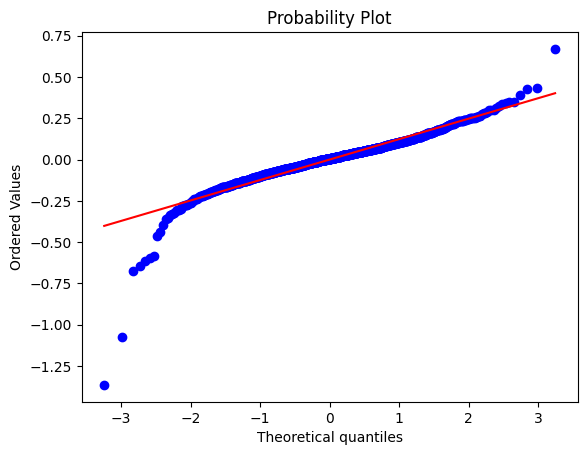

Shapiro-Wilk test: ShapiroResult(statistic=np.float64(0.8901498201347263), pvalue=np.float64(4.9363862738973715e-28))


In [15]:
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution (Log-scaled target)")
plt.show()

stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

from scipy.stats import shapiro
print("Shapiro-Wilk test:", shapiro(residuals))


####**2.4. Interpretation**:

---

After log-scaling the target variable:

* The points in the residual plot has become more evenly distributed and clustered closer to y = 0. This shows an improvement towards achieving **homoscedasticity**

* The histogram shows a reduction in the tapering to the left and the **Q-Q plot** shows that the majority of points now lie within the diagonal suggesting that we have moved closer to **Normality**

As for the metrics, we can see that there have been some improvemnt:

* The r2-score of the baseline is **85.9%** but after log-scaling y, we achieved **90.6%** which is an improvement of about **4.7 points**.

Overall, I am satisfied that we have complied the assumptions of linear regression, and that we have built a good model. Time to make improvements by feature engineering!

###**3. Feature Engineering**:

---

To get the most out of the regression models we will run, we need to engineer our features so that related ones are combined in a way that makes sense. For example all **area-related** columns will be combined to create a total area in sq.ft. or `TotalSF`. We will also do the same with year columns to create age columns.

Then we will use sklearn's built-in transformers to one-hot encode, category encode and scale our clumns.



####**3.1. Feature Creation:**

In [17]:
df_feat = df_validate.copy()
df_feat.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,1,Reg,Lvl,1,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,2.0,4.0,PConc,2.0,4.0,No,GLQ,706,Unf,0,150,856,GasA,0.0,1,SBrkr,856,854,0,1710,1,0,2,1,3,1,2.0,8,Typ,0,3.0,Attchd,2003.0,RFn,2,548,5.0,5.0,Y,0,61,0,0,0,0,3.0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,1,Reg,Lvl,1,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3.0,4.0,CBlock,2.0,4.0,Gd,ALQ,978,Unf,0,284,1262,GasA,0.0,1,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3.0,6,Typ,1,5.0,Attchd,1976.0,RFn,2,460,5.0,5.0,Y,298,0,0,0,0,0,3.0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,1,IR1,Lvl,1,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,2.0,4.0,PConc,2.0,4.0,Mn,GLQ,486,Unf,0,434,920,GasA,0.0,1,SBrkr,920,866,0,1786,1,0,2,1,3,1,2.0,6,Typ,1,5.0,Attchd,2001.0,RFn,2,608,5.0,5.0,Y,0,42,0,0,0,0,3.0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,1,IR1,Lvl,1,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3.0,4.0,BrkTil,4.0,1.0,No,ALQ,216,Unf,0,540,756,GasA,2.0,1,SBrkr,961,756,0,1717,1,0,1,0,3,1,2.0,7,Typ,1,2.0,Detchd,1998.0,Unf,3,642,5.0,5.0,Y,0,35,272,0,0,0,3.0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,1,IR1,Lvl,1,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,2.0,4.0,PConc,2.0,4.0,Av,GLQ,655,Unf,0,490,1145,GasA,0.0,1,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,2.0,9,Typ,1,5.0,Attchd,2000.0,RFn,3,836,5.0,5.0,Y,192,84,0,0,0,0,3.0,0,12,2008,WD,Normal,250000


area-related:

In [20]:
df_feat['TotalSF'] = (df_feat['TotalBsmtSF'] + df_feat['1stFlrSF'] + df_feat['2ndFlrSF'])
df_feat[['TotalSF','SalePrice']].head()

,TotalSF,SalePrice
0,2566,208500
1,2524,181500
2,2706,223500
3,2473,140000
4,3343,250000


age-related:

* `HouseAge`: age of the house at the time of selling
* `RemodAge`: age of the remodelling at the time of selling

In [21]:
df_feat['HouseAge'] = df_feat['YrSold'] - df_feat['YearBuilt']
df_feat['RemodAge'] = df_feat['YrSold'] - df_feat['YearRemodAdd']
df_feat[['HouseAge','RemodAge','SalePrice']].head()

,HouseAge,RemodAge,SalePrice
0,5,5,208500
1,31,31,181500
2,7,6,223500
3,91,36,140000
4,8,8,250000


bathroom, weighted:

In [22]:
df_feat['TotalBath'] = (df_feat['FullBath'] + 0.5 * df_feat['HalfBath'] + df_feat['BsmtFullBath'] + 0.5 * df_feat['BsmtHalfBath'])
df_feat[['TotalBath','SalePrice']].head()

,TotalBath,SalePrice
0,3.5,208500
1,2.5,181500
2,3.5,223500
3,2.0,140000
4,3.5,250000


binary features:

In [23]:
#binary features
df_feat['HasPool'] = (df_feat['PoolArea'] > 0).astype(int)
df_feat['HasGarage'] = (~df_feat['GarageType'].isna()).astype(int)
df_feat['HasFireplace'] = (df_feat['Fireplaces'] > 0).astype(int)

df_feat[['HasPool','HasGarage','HasFireplace','SalePrice']].head()

,HasPool,HasGarage,HasFireplace,SalePrice
0,0,1,0,208500
1,0,1,1,181500
2,0,1,1,223500
3,0,1,1,140000
4,0,1,1,250000


Quality and condition:

---

We combine these two since the perceptions of quality and conditions of the houses are closely related.

In [25]:
df_feat['OverallQual_Cond'] = df_feat['OverallQual'] * df_feat['OverallCond']
df_feat[['OverallQual_Cond','SalePrice']].head()

,OverallQual_Cond,SalePrice
0,35,208500
1,48,181500
2,35,223500
3,35,140000
4,40,250000


We combine all porch related columns:

In [26]:
df_feat['TotalPorchSF'] = (df_feat['OpenPorchSF'] + df_feat['EnclosedPorch'] + df_feat['3SsnPorch'] + df_feat['ScreenPorch'])
df_feat[['TotalPorchSF','SalePrice']].head()

,TotalPorchSF,SalePrice
0,61,208500
1,0,181500
2,42,223500
3,307,140000
4,84,250000


In [29]:
print(f"New shape: {df_feat.shape}")

New shape: (1460, 86)


####**3.2. define feature groups**:

In [33]:
numeric_features = df_feat.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['SalePrice', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']]

categorical_features = df_feat.select_dtypes(include=['object']).columns.tolist()

df_feat[numeric_features].columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Utilities',
       'OverallQual', 'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'MiscVal', 'MoSold', 'YrSold', 'TotalSF', 'HouseAge', 'RemodAge',
       'TotalBath', 'HasPool', 'HasGarage', 'HasFireplace', 'OverallQual_Cond',
       'TotalPorchSF'],
      dtype='object')

Remove binary cols already mapped to 0/1

In [34]:
categorical_features = [col for col in categorical_features if col not in ['CentralAir', 'Street', 'Utilities']]

####**3.3. Build Preprocessor and Pipeline:**

In [35]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [36]:
# BUILD FINAL PIPELINE

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

####**3.4. Splitting Data:**

In [38]:
# TRAIN / TEST SPLIT

X = df_feat.drop('SalePrice', axis=1)
y = np.log1p(df_feat['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####**3.5. Training and evaluation**:

In [43]:
# Train model and evaluate

pipeline.fit(X_train, y_train)

#metrics

y_pred = np.expm1(pipeline.predict(X_test))
y_test_orig = np.expm1(y_test)

r2 = r2_score(y_test_orig, y_pred)
mae = mean_absolute_error(y_test_orig, y_pred)
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)

print(f'R2 score: {r2:.4f}')
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

R2 score: 0.9245
MAE: 16232.36
MSE: 579303802.40
RMSE: 24068.73


In [44]:
model = pipeline.named_steps['regressor']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
coeffs = pd.Series(model.coef_, index=feature_names).sort_values(key=abs, ascending=False)
print(coeffs.head(20))

cat__RoofMatl_ClyTile       -2.058201
cat__Condition2_PosN        -0.748071
cat__RoofMatl_WdShngl        0.403265
cat__RoofMatl_Roll           0.380087
cat__Condition2_PosA         0.379108
cat__RoofMatl_Metal          0.341433
cat__RoofMatl_WdShake        0.328046
cat__MSZoning_C (all)       -0.311450
cat__RoofMatl_CompShg        0.306601
cat__RoofMatl_Tar&Grv        0.298769
cat__Condition2_Feedr        0.248409
cat__Functional_Sev         -0.231440
cat__Functional_Maj2        -0.213039
cat__Exterior1st_BrkComm    -0.187113
cat__Heating_Grav           -0.175492
cat__GarageYrBlt_1937.0      0.170541
cat__GarageYrBlt_1938.0     -0.165147
cat__GarageYrBlt_1924.0     -0.163273
cat__Heating_Wall            0.160694
cat__SaleCondition_Alloca    0.158697
dtype: float64


###**4. Interpretation**:

---

The optimized linear regression model achieved an **R2 score** of **0.9245**, indicating that approx 92% of the variation in housing prices can be explained by the model.

The error metrics further support this:

* **Mean Absolute Error (MAE)** of about **$16,232**

* The **Root Mean Squared Error (RMSE)** of around ** $24,069**

the model’s average prediction error is realistic compared to the price range in the dataset.

The top categorical features most strongly influence predicted prices: Roof materials such as `ClyTile`, `WdShngl`, and `Roll`, as well as housing condition factors like `Condition2_PosN` and `Condition2_PosA`

**Now we are ready to train and validate ensemble models and tune hyperparameters**

---


In [51]:
joblib.dump(pipeline, 'linear_model_pipeline.joblib')
print("pipeline saved! ")


pipeline saved! 


In [52]:
df_feat.to_csv('housing_train_featured.csv', index=False)

print(f"Model and dataset saved. Dataset shape: {df_feat.shape}")

Model and dataset saved. Dataset shape: (1460, 86)


-end notebook 3-